# 1. IMPORT DEPENDENCIES

In [13]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import librosa
import numpy as np
import tensorflow_io as tfio
import pickle

# 2.LOAD DEPENDENCIES

## 2.1 Define Paths to Files 

In [14]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Data Loading Functions

In [15]:
def load_wav_16k_mono_pyfunc(filename):
    # Define a Python function to wrap around load_wav_16k_mono
    def load_wav(filename):
        if isinstance(filename, np.ndarray):  # Check if filename is a numpy array
            filename = filename.decode('utf-8')  # Decode numpy array to string
        y, sr = librosa.load(filename.numpy().decode('utf-8'), sr=None, mono=True)
        if sr != 16000:
            y = librosa.resample(y, orig_sr=sr, target_sr=16000)
            sr = 16000
        return y

    # Wrap the Python function with tf.py_function so as to deal with the tensor string 
    y = tf.py_function(load_wav, [filename], tf.float32)
    return y

## 2.3 Plot Wave

In [16]:
wave = load_wav_16k_mono_pyfunc(CAPUCHIN_FILE)
nwave = load_wav_16k_mono_pyfunc(NOT_CAPUCHIN_FILE)


In [17]:
wave,len(wave)

(<tf.Tensor: shape=(48000,), dtype=float32, numpy=
 array([-0.05156644,  0.10698238,  0.33992097, ...,  0.0407429 ,
        -0.00256475, -0.02162626], dtype=float32)>,
 48000)

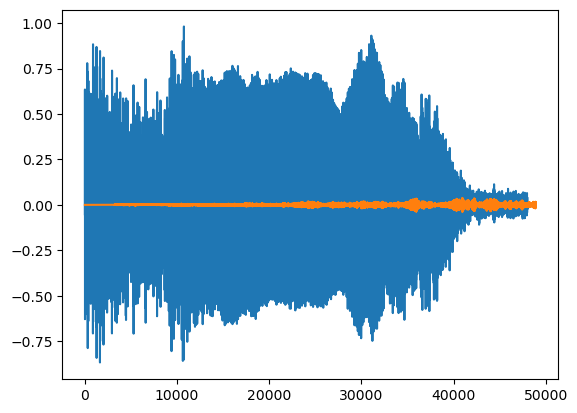

In [18]:
#just plotting magnitude of array(Y-axis) against the indexes(X-axis)
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [19]:
#Tensorflow Dataset library is useful to load up the data.
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [20]:
POS

'data/Parsed_Capuchinbird_Clips'

## 3.2 Create Tensorflow Datasets

In [21]:
# This gives a set of files as strings inside tensorflow.Dataset format so as required for preprocessing
pos = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

In [22]:
pos

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [23]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC387509-0.wav'

## 3.3 Add labels and Combine Positive and Negative Samples

In [24]:
#tf.ones(len(pos)) will make array with size that of pos comprising 1 as all elements
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [25]:
positives

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [26]:
negatives

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [27]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [28]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono_pyfunc(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [29]:
lengths

[32000,
 40000,
 64000,
 48000,
 56000,
 56000,
 72000,
 80000,
 64000,
 64000,
 48000,
 56000,
 72000,
 48000,
 72000,
 40000,
 40000,
 40000,
 56000,
 64000,
 64000,
 56000,
 48000,
 56000,
 64000,
 32000,
 48000,
 56000,
 64000,
 48000,
 40000,
 40000,
 56000,
 64000,
 48000,
 56000,
 56000,
 56000,
 32000,
 48000,
 64000,
 64000,
 56000,
 40000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 48000,
 56000,
 48000,
 56000,
 56000,
 64000,
 48000,
 56000,
 48000,
 64000,
 56000,
 56000,
 48000,
 56000,
 64000,
 64000,
 56000,
 48000,
 56000,
 48000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 40000,
 48000,
 56000,
 48000,
 64000,
 64000,
 48000,
 48000,
 56000,
 48000,
 64000,
 64000,
 56000,
 56000,
 40000,
 56000,
 64000,
 56000,
 64000,
 40000,
 56000,
 56000,
 56000,
 56000,
 56000,
 48000,
 56000,
 48000,
 64000,
 56000,
 56000,
 40000,
 48000,
 48000,
 56000,
 64000,
 48000,
 48000,
 56000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 56000,
 48000,


## 4.2 Calculate Mean, Min and Max

In [30]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [31]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [32]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [33]:
#Define your preprocess function 
import tensorflow as tf

In [34]:
def preprocess(file_path, label): 
    
    
    wav = load_wav_16k_mono_pyfunc(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    spectrogram.set_shape([1491, 257, 1])
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [35]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()


In [36]:
spectrogram, label = preprocess(filepath, label)

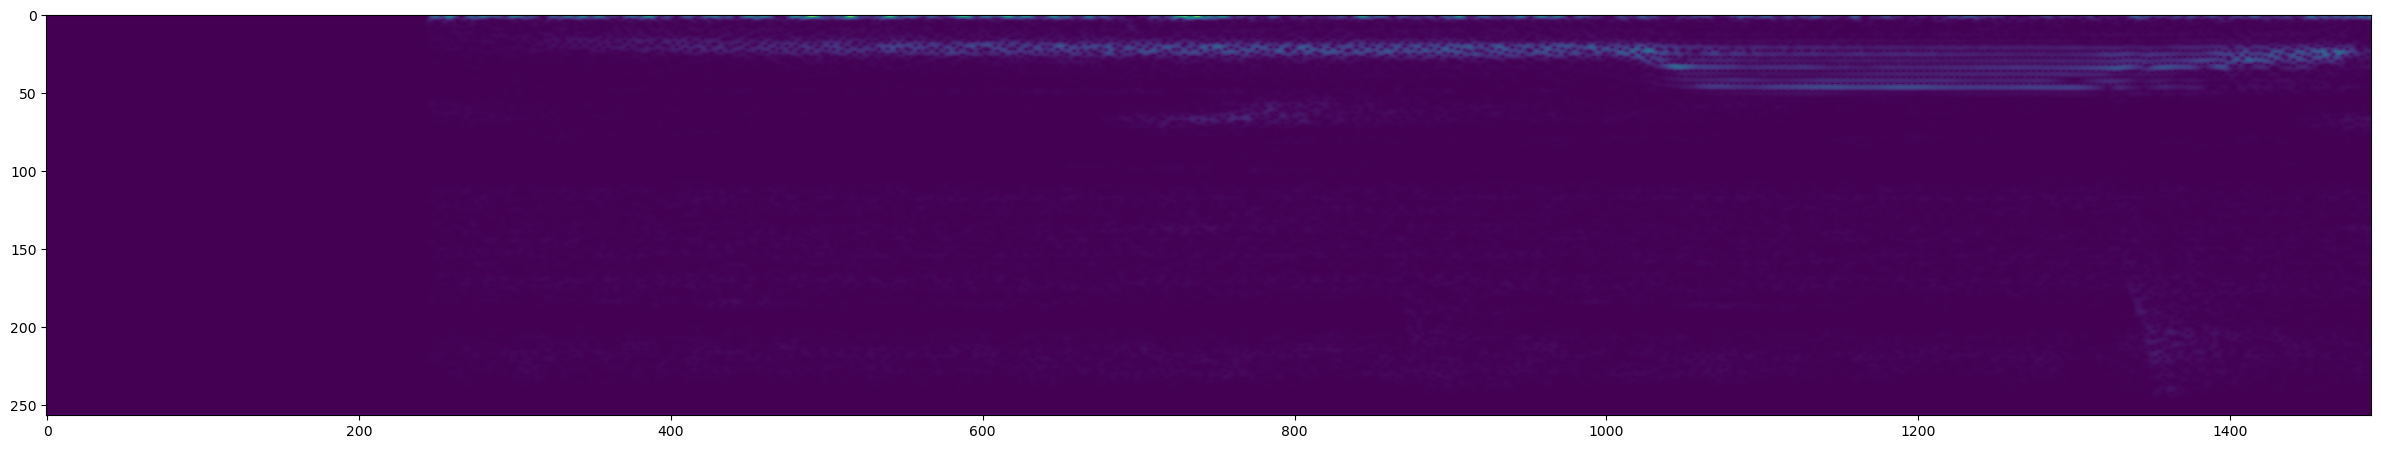

In [37]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()


# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [38]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [39]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [40]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## JUST DEBUGGING !! :)

In [29]:
dav = data.as_numpy_iterator().next()

In [30]:
def justtest(filename,label):
    print(filename)
    print(label)
    return (filename,label)

In [31]:
data.map(justtest)

Tensor("args_0:0", shape=(None, 1491, 257, 1), dtype=float32)
Tensor("args_1:0", shape=(None,), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [32]:
len(data)*.7

35.699999999999996

## 6.2 Split into Training and Testing Partitions

In [41]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [42]:
# we taking 70% of data as for training
train = data.take(36)
test = data.skip(36).take(15)

In [43]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## 6.3 Test One Batch

In [44]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [38]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/yashkumar/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6019376)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   770,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [41]:
hist = model.fit(train, epochs=4, validation_data=test)


Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 874s 24s/step - loss: 8.8007 - precision: 0.7038 - recall: 0.6927 - val_loss: 0.0108 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 801s 22s/step - loss: 0.1516 - precision: 0.9487 - recall: 0.9294 - val_loss: 0.0154 - val_precision: 0.9848 - val_recall: 1.0000
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 659s 18s/step - loss: 0.0149 - precision: 0.9835 - recall: 0.9932 - val_loss: 0.0012 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 1036s 29s/step - loss: 0.0066 - precision: 0.9964 - recall: 0.9985 - val_loss: 0.0085 - val_precision: 0.9828 - val_recall: 1.0000


In [49]:
model

<Sequential name=sequential, built=True>

In [53]:
model.save('my_model.keras')

In [46]:
loaded_model = tf.keras.models.load_model('my_model.keras')


/Users/yashkumar/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [47]:
loaded_model

<Sequential name=sequential, built=True>

In [64]:
filename = 'training_history.pkl'

# Open the file in write-binary mode
with open(filename, 'wb') as file:
    # Dump the history object into the file
    pickle.dump(hist.history, file)

In [48]:
filename = 'training_history.pkl'

# Open the file in read-binary mode
with open(filename, 'rb') as file:
    # Load the history object from the file
    loaded_history = pickle.load(file)

In [158]:
loaded_history

{'loss': [3.9319589138031006,
  0.11852608621120453,
  0.013635504059493542,
  0.02581065706908703],
 'precision': [0.8461538553237915,
  0.9605262875556946,
  0.9864864945411682,
  0.9870129823684692],
 'recall': [0.8120805621147156,
  0.948051929473877,
  0.9931972622871399,
  0.9934640526771545],
 'val_loss': [0.010751900263130665,
  0.015401803888380527,
  0.0012424923479557037,
  0.008536195382475853],
 'val_precision': [1.0, 0.9848484992980957, 1.0, 0.982758641242981],
 'val_recall': [1.0, 1.0, 1.0, 1.0]}

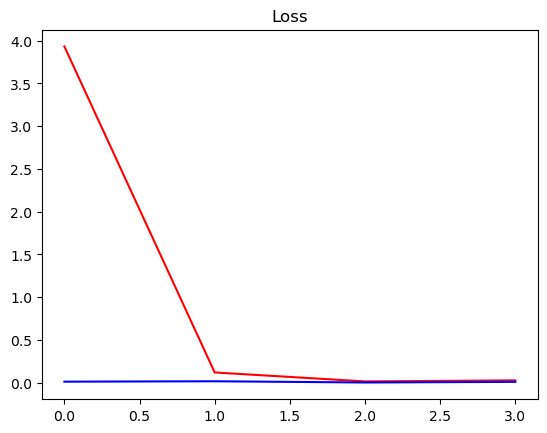

In [67]:

plt.title('Loss')
plt.plot(loaded_history['loss'], 'r')
plt.plot(loaded_history['val_loss'], 'b')
plt.show()

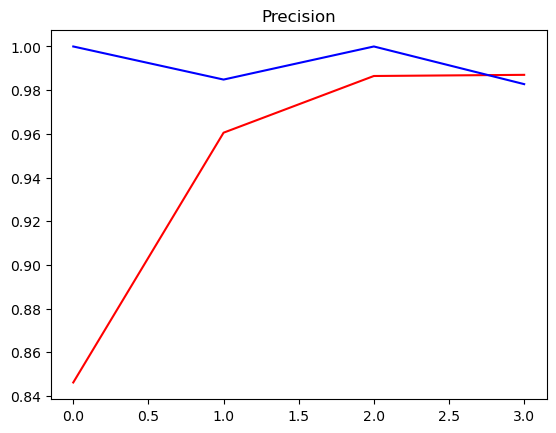

In [68]:
plt.title('Precision')
plt.plot(loaded_history['precision'], 'r')
plt.plot(loaded_history['val_precision'], 'b')
plt.show()

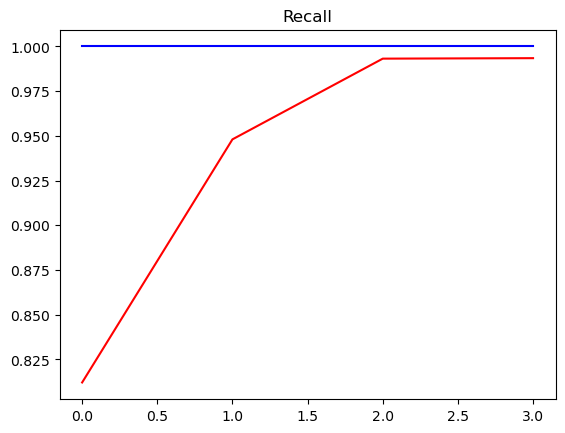

In [69]:
plt.title('Recall')
plt.plot(loaded_history['recall'], 'r')
plt.plot(loaded_history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction


In [117]:
#In X_test we are passing spectrogram and in y_test we are passing label 
X_test, y_test = test.as_numpy_iterator().next()


In [118]:
y_test.shape

(16,)

In [119]:
yhat = loaded_model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


In [120]:
yhat

array([[5.5679413e-07],
       [4.9772263e-13],
       [3.1041188e-04],
       [1.2412996e-03],
       [1.9977522e-05],
       [4.3999026e-07],
       [9.9999690e-01],
       [8.2241577e-06],
       [1.1142937e-06],
       [2.9409190e-07],
       [2.2488014e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.1622211e-03],
       [4.3905551e-08],
       [9.9977511e-01]], dtype=float32)

## 8.2 Convert Logits to Classes


In [121]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]

In [122]:
y_test

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [123]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [124]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

# 9. Build Forest Parsing Functions


## 9.1 Load up MP3s


In [128]:
    def load_mp3(filename):
        # Load the MP3 file
        wav, sr = librosa.load(filename, sr=None, mono=False)
        
        # If stereo, convert to mono
        if wav.ndim > 1:
            wav = np.mean(wav, axis=0)
        
        # Resample to 16 kHz if necessary
        if sr != 16000:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
        
        return wav

In [129]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')


In [130]:
wav = load_mp3(mp3)

In [131]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [132]:
samples, index = audio_slices.as_numpy_iterator().next()


## 9.2 Build Function to Convert Clips into Windowed Spectrograms


In [133]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions


In [134]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [136]:
yhat = loaded_model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 845ms/step


In [137]:
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## 9.4 Group Consecutive Detections


In [138]:
from itertools import groupby


In [139]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [140]:
calls


5

# 10. Make Predictions


## 10.1 Loop over all recordings and make predictions


In [142]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    if os.path.isfile(FILEPATH) and not FILEPATH.endswith('.ipynb_checkpoints'):
        wav = load_mp3(FILEPATH)
        audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
        audio_slices = audio_slices.map(preprocess_mp3)
        audio_slices = audio_slices.batch(64)
    
        yhat = loaded_model.predict(audio_slices)
    
        results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

In [144]:
results

{'recording_95.mp3': array([[5.9713283e-09],
        [8.4488130e-07],
        [7.6226287e-02],
        [9.9997473e-01],
        [9.3959543e-06],
        [2.0219541e-07],
        [4.9037345e-07],
        [8.4382838e-05],
        [6.3469046e-04],
        [3.1332657e-04],
        [8.8268802e-14],
        [6.4797814e-06],
        [5.1439730e-10],
        [1.0000000e+00],
        [1.7449545e-05],
        [1.4765885e-11],
        [3.0038554e-09],
        [1.3037052e-04],
        [1.7006699e-09],
        [3.3722742e-04],
        [2.4663788e-07],
        [1.5194762e-07],
        [1.7485059e-05],
        [3.0192756e-03],
        [4.8614828e-07],
        [3.2114339e-04],
        [1.9332024e-04],
        [6.5089844e-05],
        [2.8688381e-08],
        [1.9613009e-04],
        [4.6728394e-07],
        [6.8432992e-06],
        [1.5696381e-01],
        [9.9993306e-01],
        [6.0736312e-08],
        [9.6348444e-08],
        [6.9378126e-05],
        [8.1292437e-06],
        [8.8398465e-08],
     

## 10.2 Convert Predictions into Classes


In [145]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_95.mp3': [0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0],
 'recording_81.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_56.mp3': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_42.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections


In [146]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_95.mp3': 5,
 'recording_81.mp3': 5,
 'recording_56.mp3': 9,
 'recording_42.mp3': 0,
 'recording_43.mp3': 5,
 'recording_57.mp3': 4,
 'recording_80.mp3': 1,
 'recording_94.mp3': 3,
 'recording_82.mp3': 0,
 'recording_96.mp3': 1,
 'recording_69.mp3': 1,
 'recording_41.mp3': 0,
 'recording_55.mp3': 0,
 'recording_54.mp3': 3,
 'recording_40.mp3': 1,
 'recording_68.mp3': 1,
 'recording_97.mp3': 4,
 'recording_83.mp3': 0,
 'recording_87.mp3': 23,
 'recording_93.mp3': 5,
 'recording_44.mp3': 1,
 'recording_50.mp3': 0,
 'recording_78.mp3': 2,
 'recording_79.mp3': 0,
 'recording_51.mp3': 3,
 'recording_45.mp3': 3,
 'recording_92.mp3': 0,
 'recording_86.mp3': 4,
 'recording_90.mp3': 0,
 'recording_84.mp3': 3,
 'recording_53.mp3': 0,
 'recording_47.mp3': 5,
 'recording_46.mp3': 7,
 'recording_52.mp3': 0,
 'recording_85.mp3': 0,
 'recording_91.mp3': 0,
 'recording_09.mp3': 0,
 'recording_35.mp3': 0,
 'recording_21.mp3': 1,
 'recording_20.mp3': 0,
 'recording_34.mp3': 4,
 'recording_08.

# 11. Export Results


In [147]:
import csv


In [148]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])